# Поиск изображения по запросу

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Цель работы

Разработать демонстрационную версию поиска изображений по текстовому запросу. Модель должна:
- Получать векторные представления изображения и текста.
- Оценивать их соответствие через число от 0 до 1 (вероятность релевантности).

## План работы

**Исследовательский анализ данных**
- Агрегация экспертных оценок (например, голосование большинства).
- Объединение экспертных и краудсорсинговых оценок (возможно, с весовыми коэффициентами).
- Приведение целевой переменной к диапазону [0, 1].

**Проверка данных**

- Удаление изображений, нарушающих законодательство (например, с участием детей до 16 лет).

**Векторизация изображений**
- Использование предобученной CNN (например, ResNet-18) для извлечения признаков (исключая полносвязные слои).

**Векторизация текстов**
- Эксперименты с методами:
    - TF-IDF
    - Word2Vec
    - Трансформеры (например, BERT).

**Объединение векторов**
- Создание общего датасета с объединёнными векторами изображений, текстов и целевой переменной.

**Обучение модели предсказания соответствия**
- Разделение данных с учётом уникальности изображений (GroupShuffleSplit).
- Выбор модели (например, логистическая регрессия, градиентный бустинг или нейросеть).
- Определение метрики качества (например, ROC-AUC или кастомная метрика).

**Тестирование модели**
- Оценка качества на тестовой выборке.
- Проверка работы на данных из test_queries.csv и test_images.

## Ожидаемый результат

- Модель, предсказывающая вероятность соответствия текста и изображения (0–1).
- Метрика качества, отражающая точность ранжирования пар (например, ROC-AUC).
- Готовый пайплайн от обработки данных до предсказания для демонстрации поиска.

**Дополнительные требования:**
- Юридическая проверка изображений.
- Учёт уникальности изображений при разбиении на выборки.
- Гибкость в выборе методов векторизации и моделей.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Установка необходимых библиотек

In [1]:
import os
from typing import Generator
from pathlib import Path
from PIL import Image
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import cv2
from deepface import DeepFace
from mtcnn import MTCNN
import gensim.downloader as api

import torch
import torchvision.models as models
from torchvision import transforms

2025-08-06 01:56:04.418125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 01:56:04.429706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754438164.441932  241292 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754438164.445698  241292 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754438164.455587  241292 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Загрузка необходимых ресурсов NLTK
nltk.data.path.append('datasets/nltk_data')

### Вспомогательные функции

In [3]:
# Инициализация детектора лиц (MTCNN)
detector = MTCNN()


def has_child(image_dir: Path, img_names: pd.Series, age_threshold: int = 16) -> Generator[str, None, None]:
    """
    Проверяет, есть ли на изображении дети младше `age_threshold`.
    Возвращает наименование файла изображения на котором есть дети младше `age_threshold`.
    """

    for img_name in img_names:
        image_path = Path(image_dir) / img_name
        try:
            img = cv2.cvtColor(cv2.imread(image_path.as_posix()), cv2.COLOR_BGR2RGB)
            faces = detector.detect_faces(img)  # Детекция лиц

            for face in faces:
                x, y, w, h = face["box"]
                face_img = img[y:y + h, x:x + w]  # Обрезаем лицо

                # Оценка возраста
                analysis = DeepFace.analyze(face_img, actions=["age"], enforce_detection=False)
                if analysis[0]["age"] < age_threshold:
                    yield image_path.name

        except Exception as ex:
            print(f"Ошибка при обработке {image_path}: {ex}")


# Инициализация лемматизатора и стоп-слов
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_wordnet_pos(treebank_tag: str):
    """
    Конвертирует POS-теги Penn Treebank в формат WordNet
    """

    tag = treebank_tag[0].upper()
    tag_dict = {
        "J": nltk.corpus.wordnet.ADJ,
        "N": nltk.corpus.wordnet.NOUN,
        "V": nltk.corpus.wordnet.VERB,
        "R": nltk.corpus.wordnet.ADV
    }
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text: str, ngram: int = 1) -> set[tuple]:
    """
    Лемматизация текста и проверка слов исключений
    :param text: исходный текст
    :param ngram: количество лемм в n-грамме
    """
    
    # Токенизация и POS-тегирование
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z\s]", " ", text.lower()))
    
    # Генерируем n-граммы
    pos_tags = nltk.tag.pos_tag(tokens)
    
    # Лемматизация с учетом POS
    lemmas: list[str] = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]
    return set(nltk.ngrams(lemmas, ngram))

2025-08-06 01:56:07.623422: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Загрузка данных

In [4]:
# загружаем данные по соответствию изображения и описания, полученные в результате опроса экспертов
expert_df: pd.DataFrame = pd.read_csv(
    'datasets/ExpertAnnotations.tsv', 
    sep='\t', 
    header=None, 
    names=['image', 'desc_id', 'expert1', 'expert2', 'expert3'],
)

# загружаем данные по соответствию изображения и описания, полученные с помощью краудсорсинга
сrowd_df: pd.DataFrame = pd.read_csv(
    'datasets/CrowdAnnotations.tsv', 
    sep='\t', 
    header=None, 
    names=['image', 'desc_id', 'match_ratio', 'match_count', 'non_match_count'],
)

# загружаем информацию необходимую для обучения
train_dataset_df: pd.DataFrame = pd.read_csv('datasets/train_dataset.csv')

# загружаем информацию необходимую для тестирования
test_queries_df: pd.DataFrame = pd.read_csv('datasets/test_queries.csv', sep='|',)

In [5]:
# проверим состав данных и соответствие типов для ExpertAnnotations.tsv
expert_df.info()
expert_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5822 non-null   object
 1   desc_id  5822 non-null   object
 2   expert1  5822 non-null   int64 
 3   expert2  5822 non-null   int64 
 4   expert3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,desc_id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [6]:
# проверим состав данных и соответствие типов для CrowdAnnotations.tsv
сrowd_df.info()
сrowd_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   desc_id          47830 non-null  object 
 2   match_ratio      47830 non-null  float64
 3   match_count      47830 non-null  int64  
 4   non_match_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,desc_id,match_ratio,match_count,non_match_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [7]:
# проверим состав данных и соответствие типов для train_dataset.csv
train_dataset_df.info()
train_dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [8]:
# проверим состав данных и соответствие типов для test_queries.csv
test_queries_df.info()
test_queries_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


###  Предобработка данных

В данных датасета `train_dataset_df` данные в поле `image` не соответствуют `query_id`, исправим это.

In [9]:
train_dataset_df["image"] = train_dataset_df["query_id"].apply(lambda x: x.split("#")[0])
train_dataset_df

,image,query_id,query_text
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,2061144717_5b3a1864f0.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,2196107384_361d73a170.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,2112921744_92bf706805.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,3651971126_309e6a5e22.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [10]:
# избавимся от лишнего поля
test_queries_df = test_queries_df.drop(["Unnamed: 0"], axis=1)
test_queries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


Проверим данные на наличие дубликатов

In [11]:
print("expert_df:", expert_df.duplicated().sum())
print("сrowd_df:", сrowd_df.duplicated().sum())
print("train_dataset_df:", train_dataset_df.duplicated().sum())

expert_df: 0
сrowd_df: 0
train_dataset_df: 4845


**Вывод:**
- исправлено ошибочно заполненное поле `image` датасета `test_queries_df`
- удалено лишнее поля из датафрейма `test_queries_df`
- данные проверены на наличие дубликатов

### Поиск финального скоринга как вероятность соответствия описания картинке

#### Обработка краудсорсинговых данных
- Долю подтверждений (`match_ratio`).
- Количество подтверждений (`match_count`).
- Количество опровержений (`non_match_count`).

Можно использовать долю подтверждений (`match_ratio`) как вероятность соответствия.

#### Агрегация по большинству голосов для экспертных данных

In [12]:
# Агрегация по большинству голосов
expert_df["expert_vote"] = (expert_df[["expert1", "expert2", "expert3"]].sum(axis=1) >= 2).astype(int)

In [13]:
# Удаление строк без консенсуса (все эксперты дали разные оценки)
expert_df = expert_df[expert_df[["expert1", "expert2", "expert3"]].nunique(axis=1) != 3]

In [14]:
expert_df.head()

,image,desc_id,expert1,expert2,expert3,expert_vote
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,1
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1


#### Объединение экспертных и краудсорсинговых оценок
Есть несколько вариантов:
- Использовать только экспертные оценки (более надежные, но данных меньше).
- Использовать только краудсорсинговые оценки (больше данных, но возможен шум).
- Комбинировать оценки, например:
    - `final_score = 0.6 * expert_vote + 0.4 * match_ratio`

В данном случае воспользуемся вариантом `комбинировать оценки`

In [15]:
merged_df = pd.merge(expert_df, сrowd_df, on=["image", "desc_id"], how="inner")
merged_df["final_score"] = round(0.6 * merged_df["expert_vote"] + 0.4 * merged_df["match_ratio"], 2)

In [16]:
merged_df

,image,desc_id,expert1,expert2,expert3,expert_vote,match_ratio,match_count,non_match_count,final_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1,0.000000,0,3,0.60
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1,0.000000,0,3,0.60
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2,1,0.000000,0,3,0.60
3,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,2,3,3,1,0.333333,1,2,0.73
4,1084040636_97d9633581.jpg,3396157719_6807d52a81.jpg#2,1,2,2,1,0.000000,0,3,0.60
...,...,...,...,...,...,...,...,...,...,...
2253,979383193_0a542a059d.jpg,3244747165_17028936e0.jpg#2,2,2,2,1,0.000000,0,3,0.60
2254,979383193_0a542a059d.jpg,3482062809_3b694322c4.jpg#2,1,2,2,1,0.000000,0,3,0.60
2255,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1,0.000000,0,3,0.60
2256,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1,0.000000,0,3,0.60


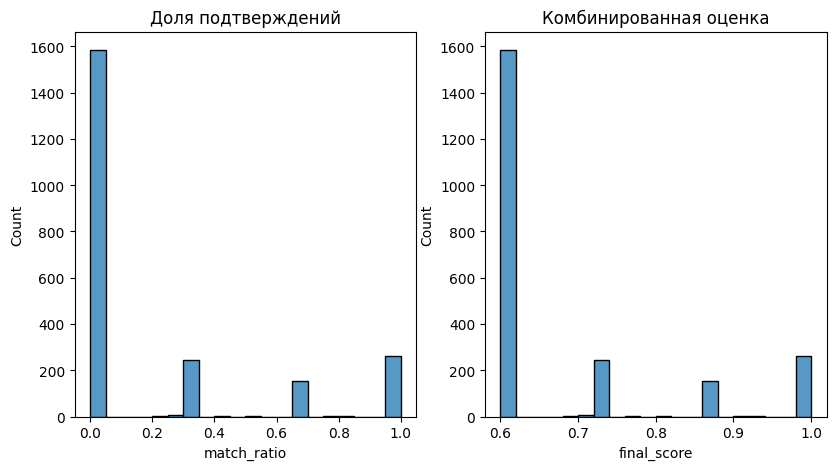

In [17]:
# Визуализация распределения оценок
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
sns.histplot(merged_df['match_ratio'], bins=20)
plt.title('Доля подтверждений')

plt.subplot(1, 3, 3)
sns.histplot(merged_df['final_score'], bins=20)
plt.title('Комбинированная оценка')
plt.show()

**Вывод:**
- была выполнена агрегация по большинству голосов для экспертных данных
- объединенили экспертные и краудсорсинговые оценок, в результате чего получили итоговый скоринг `final_score`.
- высокая доля не подтвержденных описаний экспертами
- преобладающая комбинированная оценка - 0.6

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Поскольку в вашем PoC нет автоматического определения запрещённого контента, потребуется ручная или полуавтоматическая очистка данных.

**Определение критериев для удаления:**
- В метаданных/описании необходимо найти слова которые однозначно указывают на детей и на их основе исключить изображения. Данные следует подкрепить оценкой соответствия текста и изображения для повышения точности.
- Есть лица людей, похожих на детей (возраст < 16 лет).

Основные леммы, связанные с детьми (до 16 лет)

**1. Общие термины**
- child (ребёнок)
- kid (ребёнок, разг.)
- baby (младенец, малыш)
- toddler (ребёнок 1-3 лет)
- infant (младенец, до 1 года)
- minor (несовершеннолетний)
- juvenile (несовершеннолетний, юный)
- youngster (ребёнок, подросток)

**2. Возрастные группы**
- preschooler (дошкольник, 3-5 лет)
- schoolchild / schoolkid (школьник)
- preteen (ребёнок 9-12 лет)
- pupil (ученик начальной школы)

**3. Другие связанные термины**
- underage (несовершеннолетний)
- young + boy/girl (мальчик/девочка)
- little + kid/child/boy/girl (маленький ребёнок)

In [18]:
# попробуем сначало найти ключевые биграммы
unique_bigrams: set[str] = set()
for text in train_dataset_df["query_text"].unique():
    unique_bigrams.update(get_lemmas(text, 2))

In [19]:
for row in sorted(unique_bigrams, key=lambda x: x[0]):
    if {
        "underage", 
        "young",
        "little",
        "small",       
    } & set(row):
        print(row)

('a', 'small')
('a', 'young')
('a', 'little')
('and', 'young')
('five', 'young')
('four', 'small')
('little', 'kid')
('little', 'dog')
('little', 'brown')
('little', 'girls')
('little', 'drum')
('little', 'girl')
('little', 'boy')
('little', 'child')
('own', 'little')
('small', 'plane')
('small', 'animal')
('small', 'boy')
('small', 'white')
('small', 'object')
('small', 'kangaroo')
('small', 'ball')
('small', 'child')
('small', 'waterfall')
('small', 'tree')
('small', 'black')
('small', 'dog')
('small', 'one')
('small', 'crowd')
('small', 'art')
('small', 'poster')
('small', 'girl')
('small', 'boat')
('small', 'river')
('small', 'brown')
('smile', 'little')
('the', 'small')
('the', 'young')
('the', 'little')
('three', 'small')
('three', 'young')
('three', 'little')
('two', 'little')
('two', 'small')
('while', 'young')
('with', 'small')
('young', 'adult')
('young', 'man')
('young', 'fit')
('young', 'asian')
('young', 'men')
('young', 'person')
('young', 'blond')
('young', 'girl')
('you

Из полученного списка можно выделить несколько биграмм определяющих ребенка на изображении.

In [20]:
child_phrases: set[tuple[str, str]] = {
    ('little', 'boy'),
    ('little', 'kid'),
    ('little', 'child'),
    ('little', 'girl'),
    ('little', 'girls'),
    ('small', 'girl'),
    ('small', 'boy'),
    ('small', 'child'),
    ('young', 'boy'),
    ('young', 'child'),
    ('young', 'girl'),
}

Выполним поик по ключевым словам

In [21]:
# попробуем сначало найти ключевые биграммы
unique_bigrams: set[str] = set()
for text in train_dataset_df["query_text"].unique():
    unique_bigrams.update(get_lemmas(text, 1))

In [22]:
for row in sorted(unique_bigrams, key=lambda x: x[0]):
    if {
        "child",
        "kid",
        "baby",
        "toddler", 
        "infant", 
        "minor", 
        "juvenile", 
        "youngster",
        "preschooler",
        "schoolchild",
        "schoolkid",
        "preteen",
        "pupil",
    } & set(row):
        print(row)

('baby',)
('child',)
('kid',)
('toddler',)


В результате получился следующий список:

In [23]:
child_words: set[tuple[str]] = {
    ('baby',),
    ('child',),
    ('kid',),
    ('toddler',),
}

In [24]:
def check_exception_words(text: str) -> int:
    lammas_1: set[tuple[str]] = get_lemmas(text, 1)
    lammas_2: set[tuple[str, str]] = get_lemmas(text, 2)
    if child_words & lammas_1:
        return 1
    if child_phrases & lammas_2:
        return 1
    return 0

In [25]:
# найдем слова исключения в тренировочных данных
train_dataset_df["has_child"] = train_dataset_df["query_text"].apply(check_exception_words)

In [26]:
# объеденим данные с оценками соответствия и тренировочную выборку
merged_train_dataset_df = pd.merge(train_dataset_df, merged_df[["image", "final_score"]], on=["image"], how="inner")
merged_train_dataset_df

,image,query_id,query_text,has_child,final_score
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,0.60
1,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1.00
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,0.60
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1.00
4,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,0.60
...,...,...,...,...,...
13895,2112921744_92bf706805.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0,0.60
13896,2112921744_92bf706805.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,0,0.60
13897,3651971126_309e6a5e22.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0,0.73
13898,2292406847_f366350600.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .,0,0.60


Отберем те записи у которых `final_score > 0.7` и `has_children = 1`. Значит, что картинка полностью соответствует описанию и в описании есть дети.

In [27]:
imgs_with_children = merged_train_dataset_df[
    (merged_train_dataset_df["has_child"] == 1) & (merged_train_dataset_df["final_score"] > 0.7)
]["image"].unique()
imgs_with_children.shape

(53,)

В результате 53 фотограции содержат изображения детей исходя из описания.

Попробуем найти лица людей, похожих на детей (возраст < 16 лет).

In [28]:
train_image_dir: list[str] = ["datasets", "train_images"]

In [29]:
# получим список уникальных фотографий на которых нет детей согласно описанию
imgs_without_children = train_dataset_df[~train_dataset_df["image"].isin(imgs_with_children)]["image"].unique()
print(imgs_without_children.shape)

(924,)


In [30]:
exclude_imgs: set[str] = set() 
for img_name in has_child(image_dir=Path(os.getcwd(), *train_image_dir), img_names=imgs_without_children):
    exclude_imgs.add(img_name)

2025-08-06 01:56:17.011908: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 01:56:17.352764: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 01:56:22.288228: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 01:56:28.225011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 01:56:44.642129: I tensorflow/core/framework/local_rendez

In [32]:
# добавим изображение в список исключений 
for row in exclude_imgs:
    np.append(imgs_with_children, row)

In [33]:
# получим список уникальных изображений без детей
unique_imgs = pd.DataFrame(train_dataset_df[~train_dataset_df["image"].isin(imgs_with_children)]["image"].unique(), columns=["image"])

**Вывод:**
- для поиска детей до 16 лет использовал:
    - поиск по ключевым словам и оценку соответствия текста и изображения.
    - поиск по изображению лиц младше 16 лет.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [34]:
# Загружаем предобученную ResNet18
resnet = models.resnet18(pretrained=True)

# Удаляем последний полносвязный слой (avgpool и fc)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-2]))  # Оставляем слои до avgpool

# Стандартные трансформации для ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),          # Изменение размера с сохранением пропорций
    transforms.CenterCrop(224),      # Центральное обрезание до 224x224
    transforms.ToTensor(),           # Преобразование в тензор
    transforms.Normalize(            # Нормализация
        mean=[0.485, 0.456, 0.406],  # Средние значения для ImageNet
        std=[0.229, 0.224, 0.225]   # Стандартные отклонения для ImageNet
    )
])

In [35]:
def get_image_features(image_name: str) -> np.ndarray:
    """
    Извлекает признаки (feature vector) из изображения с помощью предобученной модели.

    Параметры:
        image_name: Имя файла
        
    Возвращает:
        1D массив numpy с извлеченными признаками

    Описание работы:
        1. Загружает изображение по указанному пути
        2. Применяет препроцессинг (предполагается, что функция preprocess() определена где-то)
        3. Добавляет размерность батча для обработки моделью
        4. Пропускает изображение через модель без вычисления градиентов
        5. Усредняет признаки по пространственным измерениям (H и W)
        6. Преобразует результат в 1D numpy массив
    """

    # Загрузка и препроцессинг изображения
    img = Image.open(Path(*train_image_dir, image_name))
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)  # Добавляем размерность батча

    # Извлечение признаков
    with torch.no_grad():  # Отключаем вычисление градиентов
        features = resnet(batch_t)

    # Преобразуем 4D-тензор в 1D-вектор (усреднение по пространственным измерениям)
    features = torch.mean(features, dim=[2, 3]).squeeze()

    return features.numpy()

In [36]:
# Переводим к векторам изображения
image_features = np.stack(unique_imgs["image"].apply(get_image_features))
image_feat_df = pd.concat([unique_imgs, pd.DataFrame(image_features, columns=[f"img_feat_{i}" for i in range(image_features.shape[1])])], axis=1)
image_feat_df

,image,img_feat_0,img_feat_1,img_feat_2,img_feat_3,img_feat_4,img_feat_5,img_feat_6,img_feat_7,img_feat_8,...,img_feat_502,img_feat_503,img_feat_504,img_feat_505,img_feat_506,img_feat_507,img_feat_508,img_feat_509,img_feat_510,img_feat_511
0,2718495608_d8533e3ac5.jpg,0.940014,0.951113,0.938394,1.088151,0.999733,0.881681,0.969369,1.184438,0.980772,...,0.923946,0.869106,0.893505,0.832936,1.104018,1.017534,0.976502,0.928059,0.998232,0.939887
1,3181701312_70a379ab6e.jpg,0.833205,0.943270,0.993235,1.115214,0.919796,0.853583,0.902020,1.134699,0.961402,...,0.968411,0.908960,0.936343,0.839557,1.046722,0.971603,1.006916,0.979019,1.017599,0.943973
2,3207358897_bfa61fa3c6.jpg,0.865444,0.974603,0.919615,1.004686,0.997461,0.889810,0.946888,1.223390,1.013942,...,0.923957,0.900126,0.899411,0.863323,1.080339,0.959412,1.012937,0.896116,1.016931,0.945110
3,3286822339_5535af6b93.jpg,0.862807,0.971047,0.871881,1.027260,0.978041,0.942459,1.039212,1.161621,0.950452,...,0.943302,0.881707,0.921813,0.928709,1.103197,1.046197,0.938841,0.905221,1.054273,0.980222
4,3360930596_1e75164ce6.jpg,0.891921,0.977276,0.865718,1.073742,0.893586,0.929700,0.898458,1.240413,0.977137,...,0.950242,0.890476,0.853390,0.920935,1.174702,0.975136,0.935606,0.938209,1.023520,0.979298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2061144717_5b3a1864f0.jpg,0.918341,1.016984,0.919145,1.072676,0.946130,0.931285,0.926375,1.185830,0.907908,...,0.956422,0.925520,0.936652,0.877548,1.094697,1.034892,0.969774,0.908152,0.977581,0.970241
920,2196107384_361d73a170.jpg,0.873897,1.044450,1.073261,1.102473,0.915143,0.961400,0.943653,1.176227,1.036822,...,0.947898,0.870984,0.930988,0.916083,1.058877,1.067008,0.940301,0.955191,0.931977,0.919212
921,2112921744_92bf706805.jpg,0.926892,0.916405,0.880644,1.018692,0.926445,0.826721,0.957969,1.159893,0.946292,...,1.006909,0.846725,0.846437,0.842777,1.044329,0.989667,0.988182,0.947416,1.091076,0.891425
922,3651971126_309e6a5e22.jpg,0.981912,0.927888,0.835272,1.095697,0.954528,0.875922,0.906153,1.151213,0.971512,...,0.966225,0.876983,0.924102,0.848942,1.066060,0.940541,0.959630,0.937841,0.920551,1.005162


**Вывод:**
- для векторизации изображений использовали модель `ResNet18`
- векторизацию применили к датасету с ранее отобранными изображениями (без детей младше 16 лет)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для векторизации текста будем использовать `word2vec` модель.

**Плюсы**:
- Учитывает семантику слов
- Фиксированный размер вектора (300 в примере)
- Улавливает отношения между словами
- 
**Минусы**:
- Требует обучения (или загрузки предобученной модели)
- Потеря порядка слов (если просто усреднять)
- Не учитывает полный контекст предложения

Для баланса качества и скорости - `Word2Vec` (загрузим предобученную модель)

In [37]:
# Загрузка предобученной модели (300-мерные векторы)
w2v_model = api.load('word2vec-google-news-300')

In [ ]:
def document_vector_pretrained(text: str) -> np.ndarray:
    """
    Преобразует текст в векторное представление (документный эмбеддинг) 
    с использованием предобученной word2vec модели.
    
    Для каждого слова в тексте извлекается вектор из word2vec модели,
    затем возвращается среднее всех векторов слов (усредненный эмбеддинг документа).
    
    Параметры:
        text: Входной текст для векторного представления
        
    Возвращает:
        Векторное представление документа (усредненный вектор слов).
        Если ни одно слово не найдено в модели, возвращается нулевой вектор
        размерности w2v_model.vector_size.
    """
    words = nltk.tokenize.word_tokenize(text.lower())
    word_vectors = [w2v_model[word] for word in words if word in w2v_model]
    if len(word_vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(word_vectors, axis=0)

In [ ]:
# исключим из выборки изображения на которых содержатся изображения детей
unique_text = pd.merge(
    train_dataset_df[["image", "query_text", "final_score"]], 
    unique_imgs, 
    on=["image"], 
    how="inner",
)
unique_text

# text_embeddings = train_dataset_without_children_df["query_text"].apply(document_vector_pretrained)

# # Преобразуем в DataFrame для удобства
# text_emb_df = pd.DataFrame(text_embeddings.toarray(), columns=[f"text_feat_{i}" for i in range(text_embeddings.shape[1])])


In [ ]:
train_dataset_without_children_df

Удалим дубликаты в данных

In [ ]:
train_dataset_without_children_df = train_dataset_without_children_df.drop_duplicates(subset=["image", "query_id", "query_text", "final_score"])

In [ ]:
train_dataset_without_children_df

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска